In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sg
import scipy.stats as stats
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Button, RadioButtons, Slider
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from mathutil import threshPeriods
import ipywidgets as widgets

from callfunc import processData
from signal_process import filter_sig, hilbertfast, wavelet_decomp

### funcitons for wavelet computation

In [3]:
def doWavelet(lfp, freqs, ncycles=3):
    wavdec = wavelet_decomp(lfp, freqs=freqs)
    # wav = wavdec.cohen(ncycles=ncycles)
    wav = wavdec.colgin2009()
    wav = stats.zscore(wav)
    wav = gaussian_filter(wav, sigma=4)

    return wav

def compute(tstart, tend):
    lfpmaze = lfp[(t > tstart) & (t < tend)]
    tmaze = np.linspace(tstart, tend, len(lfpmaze))
    posmazex = posx[(post > tstart) & (post < tend)]
    posmazey = posy[(post > tstart) & (post < tend)]
    postmaze = np.linspace(tstart, tend, len(posmazex))
    speed = np.sqrt(np.diff(posmazex) ** 2 + np.diff(posmazey) ** 2)
    speed = gaussian_filter1d(speed, sigma=10)

    frgamma = np.arange(25, 50, 1)
    wav = doWavelet(lfpmaze, freqs=frgamma, ncycles=7)


    frtheta = np.arange(2, 20, 0.5)
    wav = doWavelet(lfpmaze, freqs=frtheta, ncycles=3)

def getPxx(lfp):
    window = 5 * 1250

    freq, Pxx = sg.welch(
        lfp, fs=1250, nperseg=window, noverlap=window / 6, detrend="linear",
    )
    noise = np.where(
        ((freq > 59) & (freq < 61)) | ((freq > 119) & (freq < 121)) | (freq > 220)
    )[0]
    freq = np.delete(freq, noise)
    Pxx = np.delete(Pxx, noise)

    return Pxx, freq

### Subjects/sessions to choose

In [4]:
basePath = [
    # "/data/Clustering/SleepDeprivation/RatJ/Day1/",
    # "/data/Clustering/SleepDeprivation/RatK/Day1/",
    "/data/Clustering/SleepDeprivation/RatN/Day1/",
    # "/data/Clustering/SleepDeprivation/RatJ/Day2/",
    # "/data/Clustering/SleepDeprivation/RatK/Day2/",
    # "/data/Clustering/SleepDeprivation/RatN/Day2/",
    # "/data/Clustering/SleepDeprivation/RatK/Day4/"
]

sessions = [processData(_) for _ in basePath]

### Example plots for brief periods 10s on maze

In [ ]:
cmap = mpl.cm.get_cmap("hot_r")

plt.clf()
fig = plt.figure(1, figsize=(1, 15))
gs = GridSpec(6, 4, figure=fig)
fig.subplots_adjust(hspace=0.5)


def doWavelet(lfp, freqs, ncycles=3):
    wavdec = wavelet_decomp(lfp, freqs=freqs)
    wav = wavdec.cohen(ncycles=ncycles)
    wav = stats.zscore(wav)
    wav = gaussian_filter(wav, sigma=4)

    return wav


colband = ["#CE93D8", "#1565C0", "#E65100"]

for sub, sess in enumerate(sessions):

    sess.trange = np.array([])
    posx = sess.position.x
    posy = sess.position.y
    post = sess.position.t
    maze = sess.epochs.maze

    lfp, _, _ = sess.spindle.best_chan_lfp()
    t = np.linspace(0, len(lfp) / 1250, len(lfp))

    tstart = maze[0] + 1500
    tend = maze[0] + 1510

    axgamma = fig.add_subplot(gs[0, :])
    axtheta = fig.add_subplot(gs[1, :], sharex=axgamma) 
    axpos = fig.add_subplot(gs[4:6, 0])
    axspeed = fig.add_subplot(gs[2, :], sharex=axgamma)
    axlfp = fig.add_subplot(gs[3, :], sharex=axgamma)

    def allplts(tstart, tend):
        lfpmaze = lfp[(t > tstart) & (t < tend)]
        tmaze = np.linspace(tstart, tend, len(lfpmaze))
        posmazex = posx[(post > tstart) & (post < tend)]
        posmazey = posy[(post > tstart) & (post < tend)]
        postmaze = np.linspace(tstart, tend, len(posmazex))
        speed = np.sqrt(np.diff(posmazex) ** 2 + np.diff(posmazey) ** 2)
        speed = gaussian_filter1d(speed, sigma=10)

        axgamma.clear()
        frgamma = np.arange(25, 50, 1)
        wav = doWavelet(lfpmaze, freqs=frgamma, ncycles=7)
        axgamma.pcolorfast(tmaze, frgamma, wav, cmap="jet")
        axgamma.set_xlim([tstart, tend])
        axgamma.set_ylabel("Frequency")

        axtheta.clear()
        frtheta = np.arange(2, 20, 0.5)
        wav = doWavelet(lfpmaze, freqs=frtheta, ncycles=3)
        axtheta.pcolorfast(tmaze, frtheta, wav, cmap="jet")
        axtheta.set_ylabel("Amplitude")

        colpos = [cmap(_ / len(posmazex)) for _ in range(len(posmazex))]
        axpos.clear()
        axpos.plot(posx, posy, color="#bfc0c0", zorder=1)
        # axpos.plot(postmaze, posmazex, "k")
        # axpos.plot(postmaze, posmazey, "r")
        axpos.scatter(posmazex, posmazey, s=3, zorder=2, c=colpos)
        axpos.axis("off")

        axspeed.clear()
        # axspeed.plot(postmaze[:-1], np.abs(np.diff(posmazex)), "k")
        # axspeed.plot(postmaze[:-1], np.abs(np.diff(posmazey)), "r")
        axspeed.plot(postmaze[:-1], speed, "k")
        axspeed.set_ylabel("Speed (a.u.)")

        axlfp.clear()
        axlfp.plot(tmaze, lfpmaze, "k")
        axlfp.set_xlabel("Time (s)")
        axlfp.set_ylabel("Amplitude")

    allplts(tstart, tend)

    # ax = fig.add_subplot(gs[5, 1:])
    # axcolor = "lightgoldenrodyellow"
    # # axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    # timetoPlot = Slider(
    #     ax, "Time", maze[0], maze[1], valinit=tstart, valstep=10, fc="gray"
    # )
    @widgets.interact(time=(maze[0], maze[1], 10))
    def update(time=tstart):
        # tnow = timetoPlot.val
        allplts(time - 5, time + 5)
        # l.set_ydata(amp * np.sin(2 * np.pi * freq * t))
        # fig.canvas.draw_idle()

    # timetoPlot.on_changed(update)
    # samp.on_changed(update)



### Calculate strong theta periods in MAZE

In [5]:
cmap = mpl.cm.get_cmap("hot_r")

plt.clf()
fig = plt.figure(1, figsize=(1, 15))
gs = GridSpec(6, 4, figure=fig)
fig.subplots_adjust(hspace=0.5)


def doWavelet(lfp, freqs, ncycles=3):
    wavdec = wavelet_decomp(lfp, freqs=freqs)
    wav = wavdec.cohen(ncycles=ncycles)
    wav = stats.zscore(wav)
    wav = gaussian_filter(wav, sigma=4)

    return wav


colband = ["#CE93D8", "#1565C0", "#E65100"]

for sub, sess in enumerate(sessions):

    sess.trange = np.array([])
    posx = sess.position.x
    posy = sess.position.y
    post = sess.position.t
    maze = sess.epochs.maze

    lfp, _, _ = sess.spindle.best_chan_lfp()
    t = np.linspace(0, len(lfp) / 1250, len(lfp))

    tstart = maze[0] + 1500
    tend = maze[0] + 1510

    lfp, _, _ = sess.spindle.best_chan_lfp()
    t = np.linspace(0, len(lfp) / 1250, len(lfp))

    tstart = maze[0]
    tend = maze[1] 

    lfpmaze = lfp[(t > tstart) & (t < tend)]
    tmaze = np.linspace(tstart, tend, len(lfpmaze))
    posmazex = posx[(post > tstart) & (post < tend)]
    posmazey = posy[(post > tstart) & (post < tend)]
    postmaze = np.linspace(tstart, tend, len(posmazex))
    speed = np.sqrt(np.diff(posmazex) ** 2 + np.diff(posmazey) ** 2)
    speed = gaussian_filter1d(speed, sigma=10)

    frgamma = np.arange(25, 50, 1)
    wavgamma = doWavelet(lfpmaze, freqs=frgamma, ncycles=7)

    frtheta = np.arange(2, 20, 0.5)
    wavtheta = doWavelet(lfpmaze, freqs=frtheta, ncycles=3)



<Figure size 720x1008 with 0 Axes>

### Calclulate average spectrum aroung theta cycle

/home/bapung/Documents/MATLAB/pythonprogs/ModulesPath/signal_process.py:180: ComplexWarning: Casting complex values to real discards the imaginary part
  * np.exp(2j * np.pi * freq * t_wavelet)


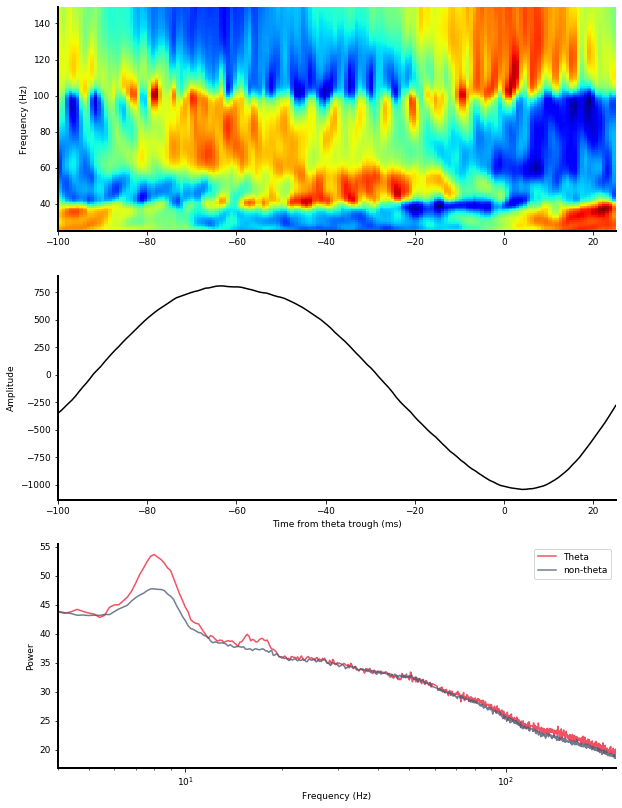

In [12]:
cmap = mpl.cm.get_cmap("hot_r")
for sub, sess in enumerate(sessions):

    sess.trange = np.array([])
    eegSrate= sess.recinfo.lfpSrate
    posx = sess.position.x
    posy = sess.position.y
    post = sess.position.t
    maze = sess.epochs.maze

    lfp, _, _ = sess.ripple.best_chan_lfp()
    lfp= lfp[0,:]
    t = np.linspace(0, len(lfp) / 1250, len(lfp))

    tstart = maze[0]
    tend = maze[1] 

    lfpmaze = lfp[(t > tstart) & (t < tend)]
    tmaze = np.linspace(tstart, tend, len(lfpmaze))
    posmazex = posx[(post > tstart) & (post < tend)]
    posmazey = posy[(post > tstart) & (post < tend)]
    postmaze = np.linspace(tstart, tend, len(posmazex))
    speed = np.sqrt(np.diff(posmazex) ** 2 + np.diff(posmazey) ** 2)
    speed = gaussian_filter1d(speed, sigma=10)


    frtheta = np.arange(5, 12, 0.5)
    wavdec = wavelet_decomp(lfpmaze, freqs=frtheta)
    wav = wavdec.cohen()
    # frgamma = np.arange(25, 50, 1)
    # wavdec = wavelet_decomp(lfpmaze, freqs=frgamma)
    # wav = wavdec.colgin2009()
    # wavtheta = doWavelet(lfpmaze, freqs=frtheta, ncycles=3)

    sum_theta = gaussian_filter1d(np.sum(wav,axis=0),sigma=10)
    zsc_theta = stats.zscore(sum_theta)
    thetaevents = threshPeriods(zsc_theta,lowthresh=0,highthresh=1.5,minDistance=300,minDuration=1250)

    strong_theta= []
    theta_indices = [] 
    for (beg,end) in thetaevents:
        strong_theta.extend(lfpmaze[beg:end])
        theta_indices.extend(np.arange(beg,end))
    strong_theta=np.asarray(strong_theta)
    theta_indices = np.asarray(theta_indices)

    non_theta = np.delete(lfpmaze,theta_indices)
    frgamma = np.arange(25, 150, 1)
    # frgamma = np.linspace(25, 150, 1)
    wavdec = wavelet_decomp(strong_theta, freqs=frgamma)
    wav = wavdec.colgin2009()
    # wav = wavdec.cohen(ncycles=7)
    wav = stats.zscore(wav)

    theta_filter = stats.zscore(filter_sig.filter_cust(strong_theta,lf=4,hf=11))
    hil_theta = hilbertfast(theta_filter)
    theta_amp = np.abs(hil_theta)
    theta_angle = np.angle(hil_theta, deg=True) + 180

    theta_troughs = sg.find_peaks(-theta_filter)[0]

    avg_theta = np.zeros(156)
    mean_gamma = np.zeros((wav.shape[0],156))
    for i in theta_troughs[1:]:
        mean_gamma = mean_gamma+ wav[:,i-125:i+31]
        avg_theta = avg_theta + strong_theta[i-125:i+31]

    mean_gamma=mean_gamma/len(theta_troughs)

    mean_gamma = stats.zscore(mean_gamma,axis=1)


    plt.clf()
    fig = plt.figure(1, figsize=(10, 15))
    gs = gridspec.GridSpec(3, 1, figure=fig)
    fig.subplots_adjust(hspace=0.2)

    ax = fig.add_subplot(gs[0])
    t_thetacycle = np.linspace(-100,25,156)
    ax.pcolorfast(t_thetacycle,frgamma,mean_gamma,cmap='jet')
    ax.set_ylabel('Frequency (Hz)')

    # ax.contourf(t_thetacycle,frgamma,mean_gamma)
    ax.set_xlim([-100,25])
    ax = fig.add_subplot(gs[1],sharex=ax)
    ax.plot(t_thetacycle,avg_theta/len(theta_troughs),'k')
    ax.set_xlabel('Time from theta trough (ms)')
    ax.set_ylabel('Amplitude')

    ax = fig.add_subplot(gs[2])
    todB = lambda power: 10 * np.log10(power)
    pxx_theta, f_theta = getPxx(strong_theta)
    pxx_nontheta, f_nontheta = getPxx(non_theta)
    ax.plot(f_theta, todB(pxx_theta), color="#ef253c", alpha=0.8)
    ax.plot(f_theta, todB(pxx_nontheta), color="#4e5c73", alpha=0.8)
    ax.set_xscale('log')
    ax.set_xlim([4, 220])
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.legend(['Theta', 'non-theta'])